## Analysis of flat10MIP output

In [168]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/work/aswann/conda-envs/xcdat_plus/lib/python3.11/site-packages/xarray/core/options.py:121: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM

MPI-ESM1-2-LR also did the experiments but I don't see any ouptut on NIRD

Directory structures within each model folder vary - need to account for this 

#### Time indexing
There is a pretty good chance that each model did it's time indexing in a different way. 

Will start by making one dataset for each model-experiment combo.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella)
I tried to find matching grid files but none of the GISS models from CMIP6 appear to have the same resolution as the data from flat10

In [96]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist= ['ACCESS-ESM1-5',  
            'CESM2',  
            'CNRM-ESM2-1',  
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM']

# python dislikes filenames with dashes
modellist_safe = ['ACCESS',
                  'CESM2',
                  'CNRM',
                  'GFDL',
                  'GISS',
                  'NorESM2']

caltype = ['DatetimeProlepticGregorian',
           'DatetimeNoLeap',
           'DatetimeGregorian',
           'DatetimeNoLeap',
           'year',
           'DatetimeNoLeap']

startdate = [101, 1, 1850, 1, 1850, 1850]

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

In [245]:
#---- get grid info

grid_info = {}

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        print(model +' getting grid info')
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

        # add to the dictionary
        grid_info[model +'_areacella'] = areacella
        grid_info[model +'_landfrac'] = landfrac

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
CNRM-ESM2-1 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 does not have grid info
NorESM2-LM getting grid info


## Define functions

In [ ]:
def plot_all_models_one_deltavar(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,14))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print(model)    
        # create datasets for each model + experiment combination + variable
        dsl=data_dict[model +'_' +run]
        ds=dsl[var]
        
        ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())

        if model == 'GISS_E2.1':
            arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
        else:
            arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))
    
        fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
    
        fg.axes.coastlines()
        plt.title(model)
    
    # add a title over the whole figure with the name of the run
    fig.suptitle(run)
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [256]:
def plot_all_models_zonal_by_time(var, run, modellist, modellist_safe):
    # zonal plots
    
   
    #def plot_all_models_one_var(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,12))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
    
        # create datasets for each model + experiment combination + variable
        dsl=data_dict[model +'_' +run]
        ds=dsl[var]
        
        ax=plt.subplot(3,2,m+1)
    
        if model == 'GISS_E2.1':
            arg=(ds.mean(dim='lon'))
        else:
            arg=(ds.mean(dim='lon'))
    
        fg = arg.plot(x='lat',cmap='YlGn')
        plt.xlim([-90, 90])
        
        plt.title(model)
    
    fig.suptitle(run)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [ ]:
def plot_all_models_zonal_by_time(var, run, modellist, modellist_safe):
    # zonal plots
    
   
    #def plot_all_models_one_var(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,12))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
    
        # create datasets for each model + experiment combination + variable
        exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
        print(exestr)
        exec(exestr, globals())
        #ds = model_run.var
        
        ax=plt.subplot(3,2,m+1)
    
        if model == 'GISS_E2.1':
            arg=(ds.mean(dim='lon'))
        else:
            arg=(ds.mean(dim='lon'))
    
        fg = arg.plot(x='lat',cmap='YlGn')
        plt.xlim([-90, 90])
        
        plt.title(model)
    
    fig.suptitle(run)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

## Land carbon budget over time

pools:  
cVeg, cLitter, cSoil

fluxes:  
nbp, npp, gpp, ra, rh



In [99]:
varlist=['cVeg', 'cLitter', 'cSoil', 'nbp']#, 'gpp', 'ra', 'rh']#, 'npp']

# there seems to be a problem with ra for NorESM

In [100]:
# Test out a search path for one model and variabile
model = 'NorESM2-LM'
run = '*zec'
var='cSoil'


searchpath= outputdir +model +'/' +run +'/' +var +'*.nc'

filenamelist= glob.glob(searchpath)

#ds = xr.open_dataset(pathtofile)


filenamelist

['/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_214001-214912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_198001-198912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_208001-208912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_203001-203912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_201001-201912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoilSlow_Lmon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_196001-196912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_213001-213912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_

In [102]:
ds1 = xr.open_dataset(filenamelist[0], use_cftime=True)
ds2 = xr.open_dataset(filenamelist[1], use_cftime=True)

In [103]:
dsm=xr.concat([ds1,ds2],dim='time')

dsm

<xarray.Dataset>
Dimensions:    (time: 240, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 2140-01-16 12:00:00 ... 1989-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 2140-01-01 00:00:00 ... 1990-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.05 -89.05 ... 89.05 90.0
    lon_bnds   (time, lon, bnds) float64 -1.25 1.25 1.25 ... 356.2 356.2 358.7
    cSoil      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1851-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               cSoil
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/86189965-c80a-4e3c-ae6f-8a53126811a8

In [253]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

# initialize an empty dictionary
data_dict ={}

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

        print('adding ' +model +' ' +runlist[r] +' to dict')
        # save output to a dictionary
 #       if m == 0 & r == 0:
  #          # create a dictonary of the xarrays
   #         data_dict = {model +'_' +runlist[r]: dsmerge_v}
    #    else:
        # add to the dictionary
        data_dict[model +'_' +runlist[r]] = dsmerge_v


adding ACCESS-ESM1-5 flat10 to dict
adding ACCESS-ESM1-5 flat10_zec to dict
adding ACCESS-ESM1-5 flat10_cdr to dict
adding CESM2 flat10 to dict
adding CESM2 flat10_zec to dict
adding CESM2 flat10_cdr to dict
adding CNRM-ESM2-1 flat10 to dict
adding CNRM-ESM2-1 flat10_zec to dict
adding CNRM-ESM2-1 flat10_cdr to dict
adding GFDL-ESM4 flat10 to dict
adding GFDL-ESM4 flat10_zec to dict
adding GFDL-ESM4 flat10_cdr to dict
adding GISS_E2.1 flat10 to dict
adding GISS_E2.1 flat10_zec to dict
adding GISS_E2.1 flat10_cdr to dict
adding NorESM2-LM flat10 to dict
adding NorESM2-LM flat10_zec to dict
adding NorESM2-LM flat10_cdr to dict


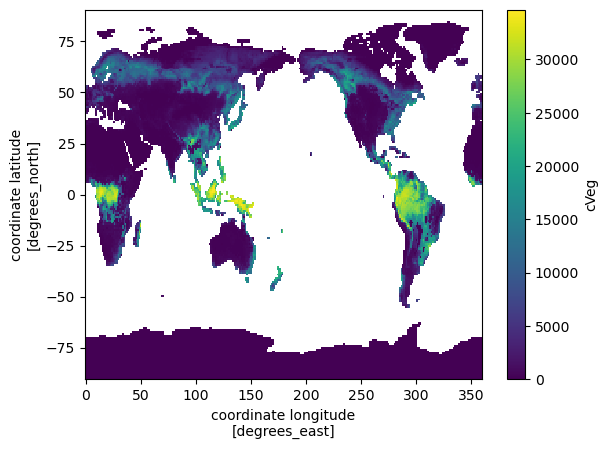

In [250]:
CESM2_flat10=data_dict['CESM2_flat10']
CESM2_flat10.cVeg.mean(dim='time').plot()


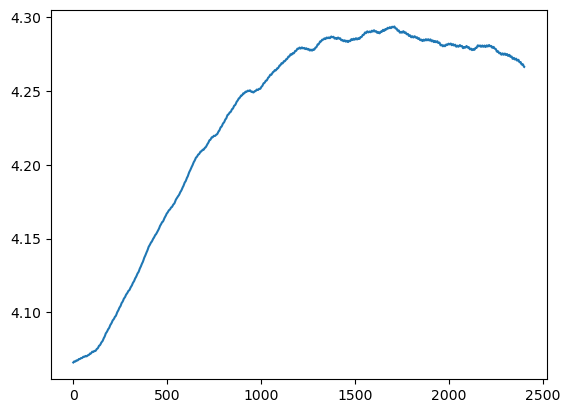

In [254]:
ACCESS_flat10=data_dict['ACCESS-ESM1-5_flat10']
plt.plot(ACCESS_flat10.cSoil.mean(dim=['lat','lon']).values)


# Plot data

### Plot map of change in carbon on land
carbon on land = cVeg + cSoil + cLitter  

some models do not have cLitter?


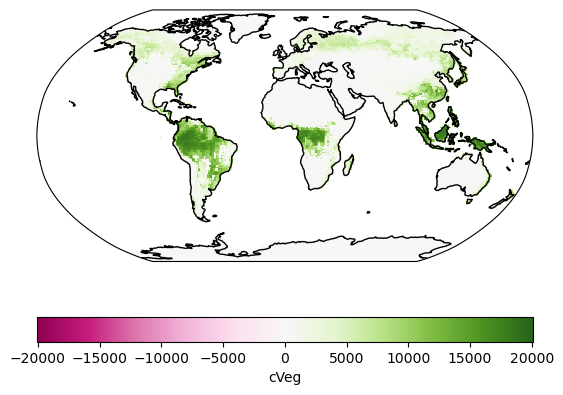

In [108]:
CESM2_flat10=data_dict['CESM2_flat10']
# make the plot entirely with xarray.plot function

arg=(CESM2_flat10.cVeg[-23:-1,:,:].mean(dim='time')-CESM2_flat10.cVeg[0:23,:,:].mean(dim='time'))

fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
fg.axes.coastlines()

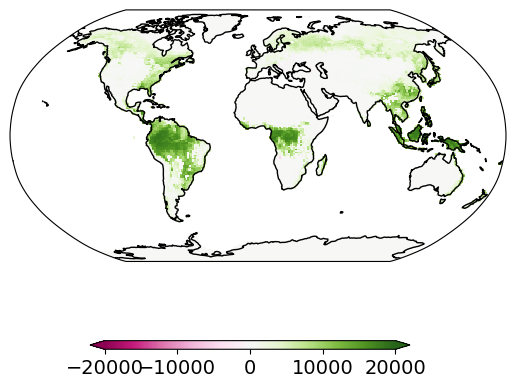

In [116]:
# make the plot using arrays and cartopy

mapdata=(CESM2_flat10.cVeg[-23:-1,:,:].mean(dim='time')-CESM2_flat10.cVeg[0:23,:,:].mean(dim='time')).values

lat = CESM2_flat10['lat'].values
lon = CESM2_flat10['lon'].values

ax = plt.axes(projection=ccrs.Robinson())
#        ax.set_extent([-140, -75, 15, 75], ccrs.PlateCarree())
ax.coastlines()

#-- Make the actual Plot
cs = plt.pcolormesh(lon,lat,mapdata, transform=ccrs.PlateCarree())#PlateCarree())#Robinson())#
plt.set_cmap(cmap='PiYG')

# set color limits
plt.clim([-20000, 20000]) 

# add a colorbar:
# make an axes for the colorbar
#cax = plt.axes([left, bottom, width, height])
cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')
cbar = plt.colorbar(cax=cax,orientation='horizontal',extend='both')#,pad=.02, shrink=0.9) #use cax here, which means getting rid of pad
cbar.ax.tick_params(labelsize=14) 



### Use plotting function to plot maps from all models at once

ACCESS-ESM1-5
ds=ACCESS_flat10.cVeg
CESM2
ds=CESM2_flat10.cVeg
CNRM-ESM2-1
ds=CNRM_flat10.cVeg
GFDL-ESM4
ds=GFDL_flat10.cVeg
GISS_E2.1
ds=GISS_flat10.cVeg
NorESM2-LM
ds=NorESM2_flat10.cVeg


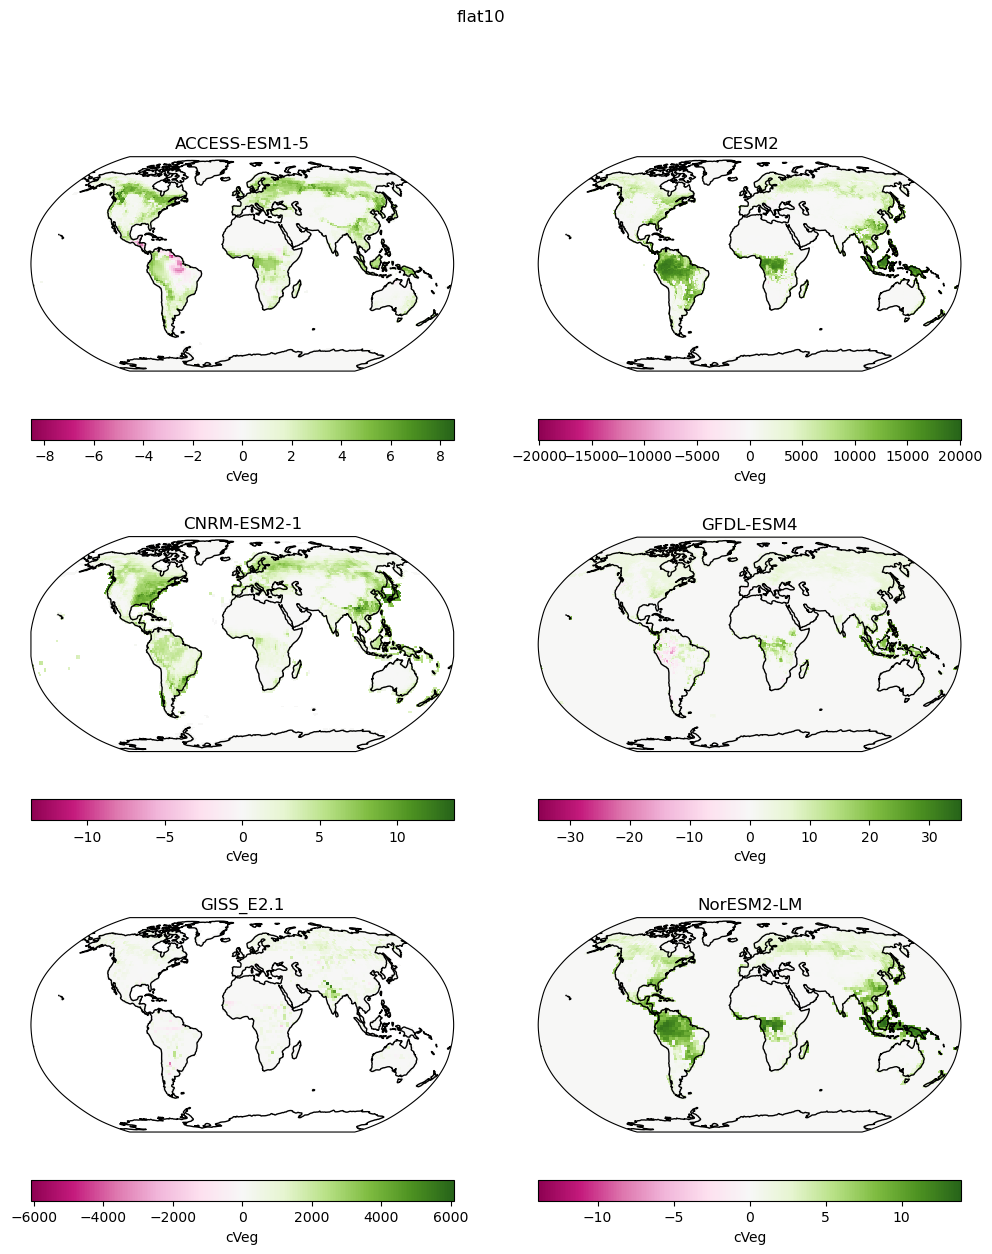

done saving file


In [139]:
# Plotting cVeg for flat10

run=runlist[0]
var='cVeg'

plot_all_models_one_deltavar(var, run, modellist, modellist_safe)

ACCESS-ESM1-5
ds=ACCESS_flat10_zec.cVeg
CESM2
ds=CESM2_flat10_zec.cVeg
CNRM-ESM2-1
ds=CNRM_flat10_zec.cVeg
GFDL-ESM4
ds=GFDL_flat10_zec.cVeg
GISS_E2.1
ds=GISS_flat10_zec.cVeg
NorESM2-LM
ds=NorESM2_flat10_zec.cVeg


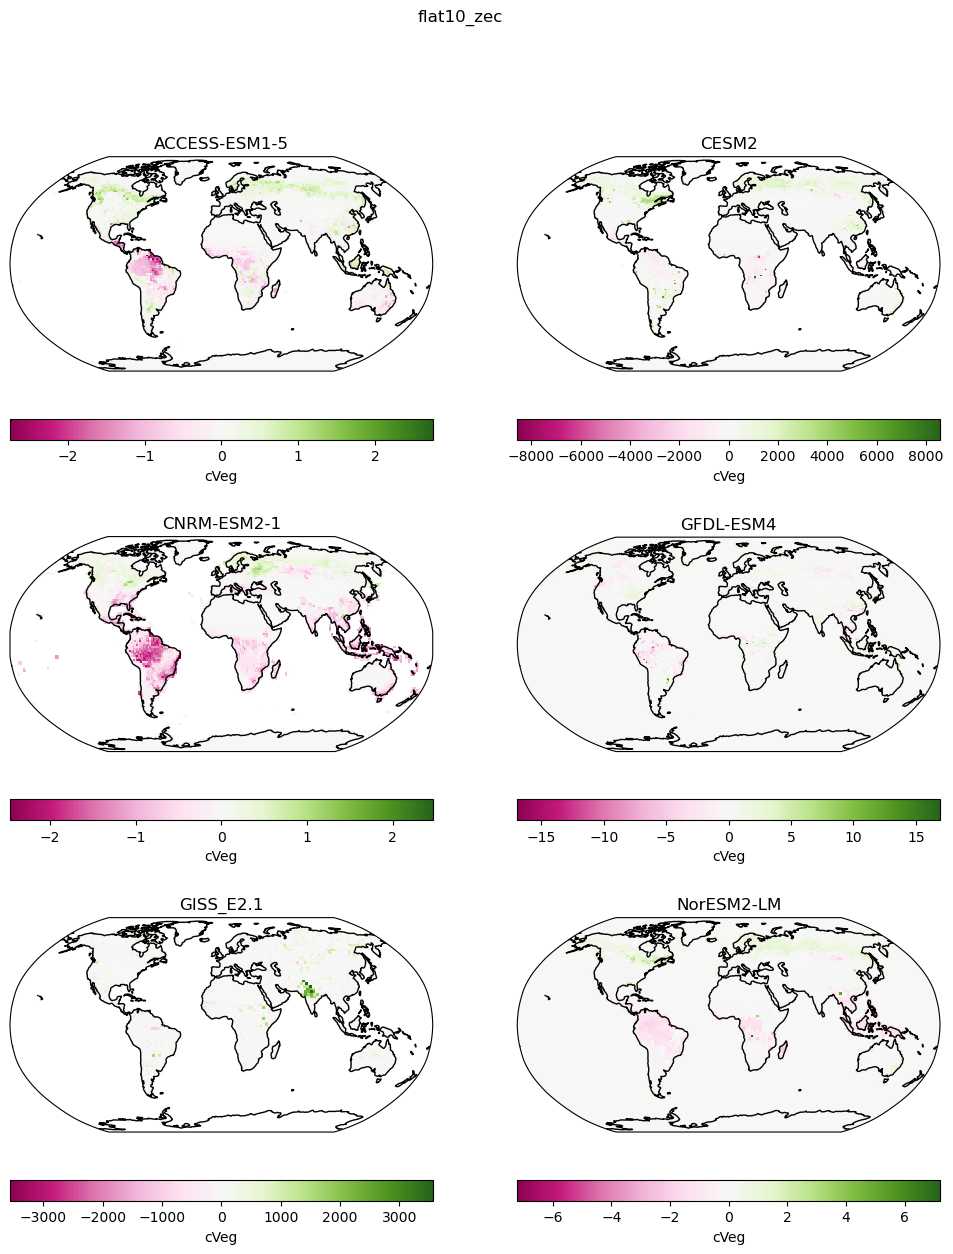

done saving file


In [140]:
# Plotting cVeg for flat10zec

run=runlist[1]
var='cVeg'

plot_all_models_one_deltavar(var, run, modellist, modellist_safe)

ACCESS-ESM1-5
ds=ACCESS_flat10_cdr.cVeg
CESM2
ds=CESM2_flat10_cdr.cVeg
CNRM-ESM2-1
ds=CNRM_flat10_cdr.cVeg
GFDL-ESM4
ds=GFDL_flat10_cdr.cVeg
GISS_E2.1
ds=GISS_flat10_cdr.cVeg
NorESM2-LM
ds=NorESM2_flat10_cdr.cVeg


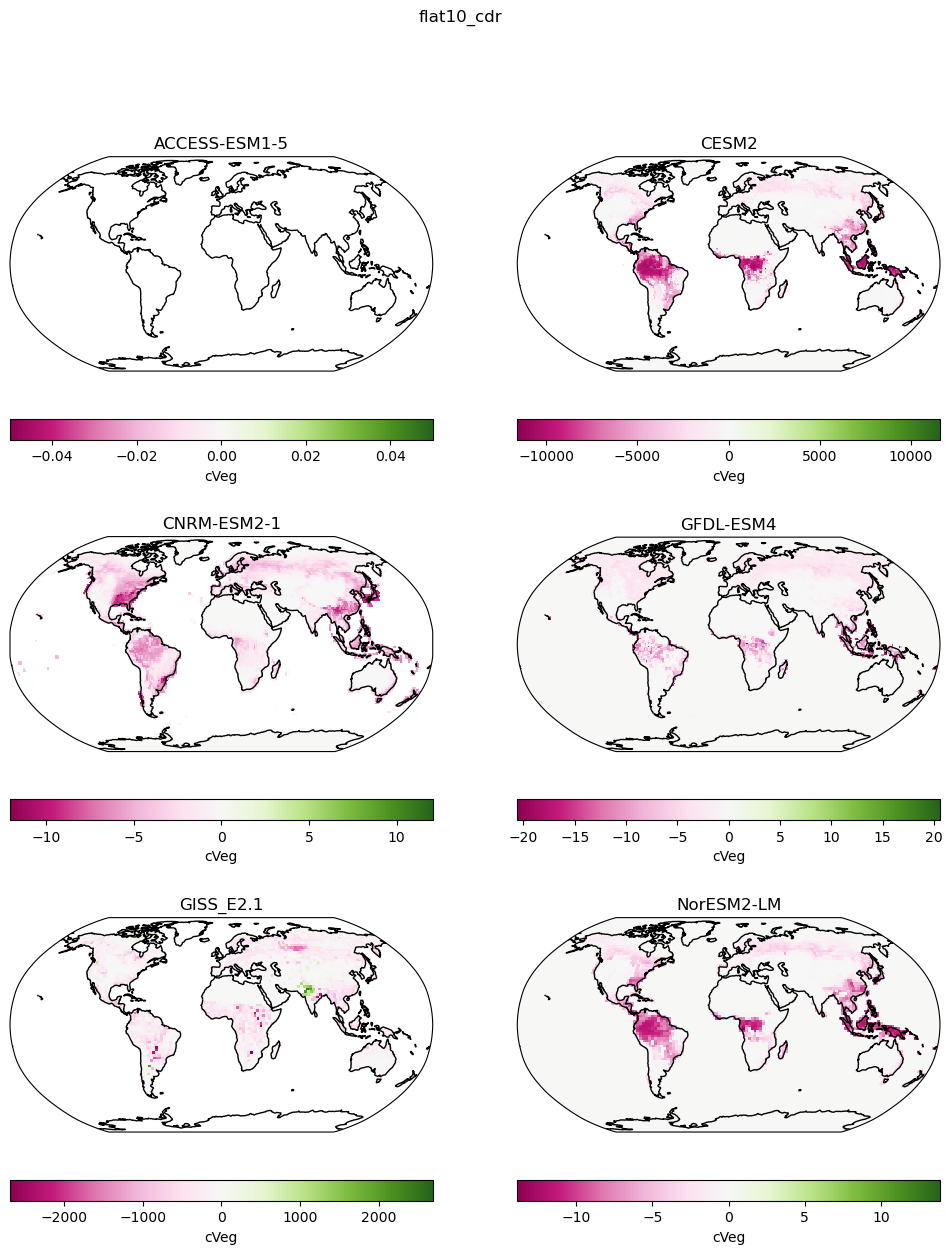

done saving file


In [141]:
# Plotting change in cVeg for flat10cdr

run=runlist[2]
var='cVeg'

plot_all_models_one_deltavar(var, run, modellist, modellist_safe)

In [ ]:
# now zonal profiles

ds=ACCESS_flat10.cVeg
ds=CESM2_flat10.cVeg
ds=CNRM_flat10.cVeg
ds=GFDL_flat10.cVeg
ds=GISS_flat10.cVeg
ds=NorESM2_flat10.cVeg


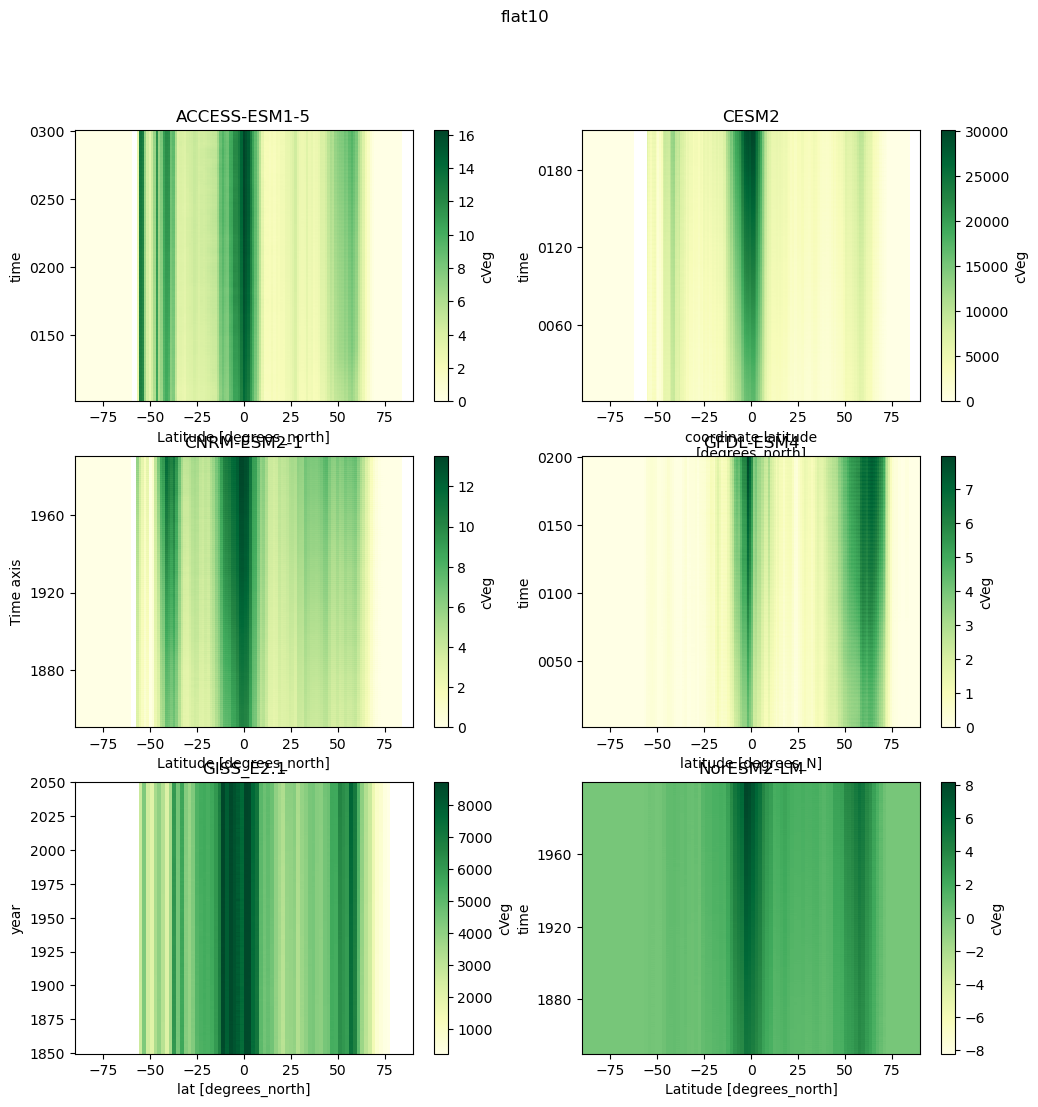

done saving file


In [149]:
# zonal by time plots
run=runlist[0]
var='cVeg'

plot_all_models_zonal_by_time(var, run, modellist, modellist_safe)

ds=ACCESS_flat10_zec.cVeg
ds=CESM2_flat10_zec.cVeg
ds=CNRM_flat10_zec.cVeg
ds=GFDL_flat10_zec.cVeg
ds=GISS_flat10_zec.cVeg
ds=NorESM2_flat10_zec.cVeg


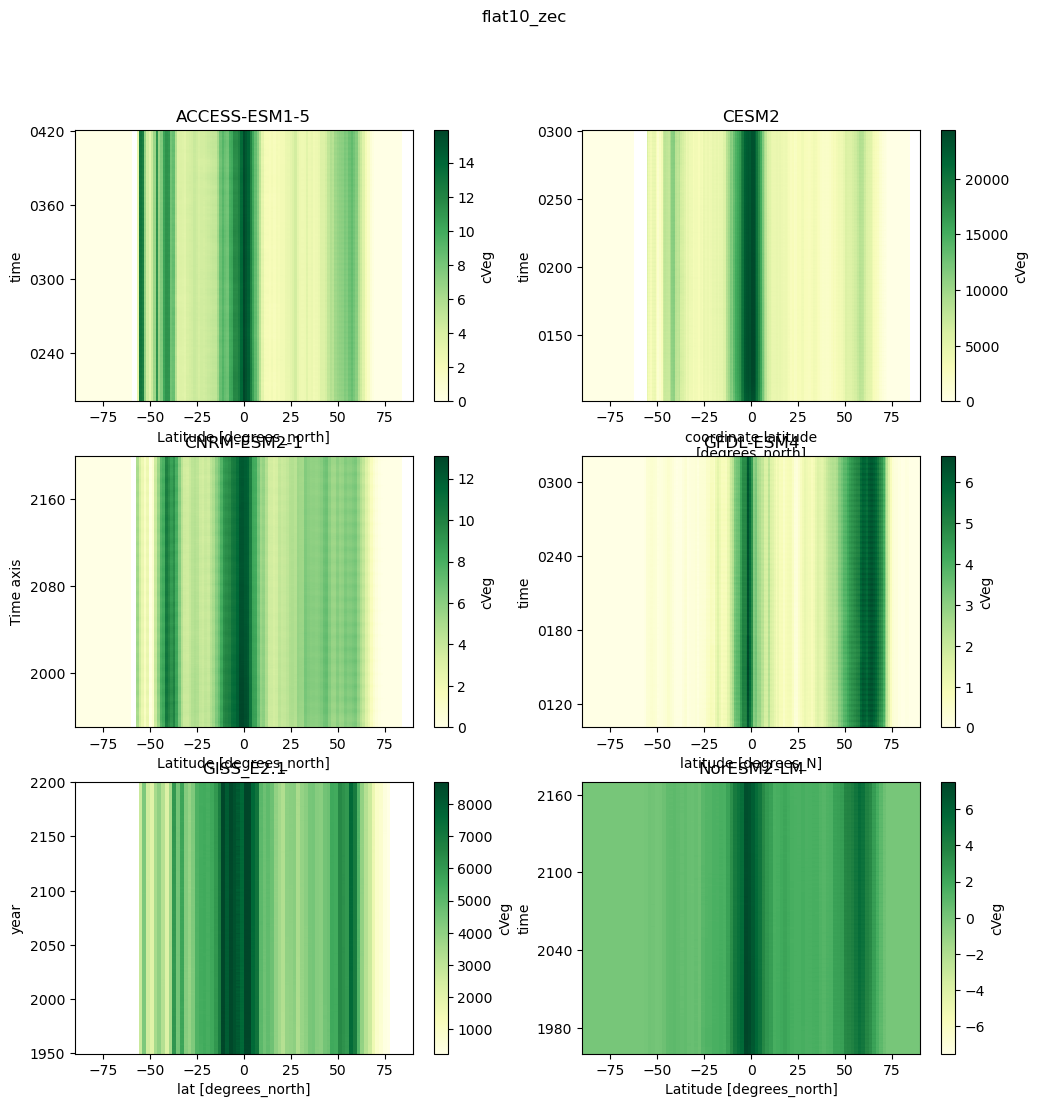

done saving file


In [150]:
# zonal by time plots
run=runlist[1]
var='cVeg'

plot_all_models_zonal_by_time(var, run, modellist, modellist_safe)

ds=ACCESS_flat10_cdr.cVeg
ds=CESM2_flat10_cdr.cVeg
ds=CNRM_flat10_cdr.cVeg
ds=GFDL_flat10_cdr.cVeg
ds=GISS_flat10_cdr.cVeg
ds=NorESM2_flat10_cdr.cVeg


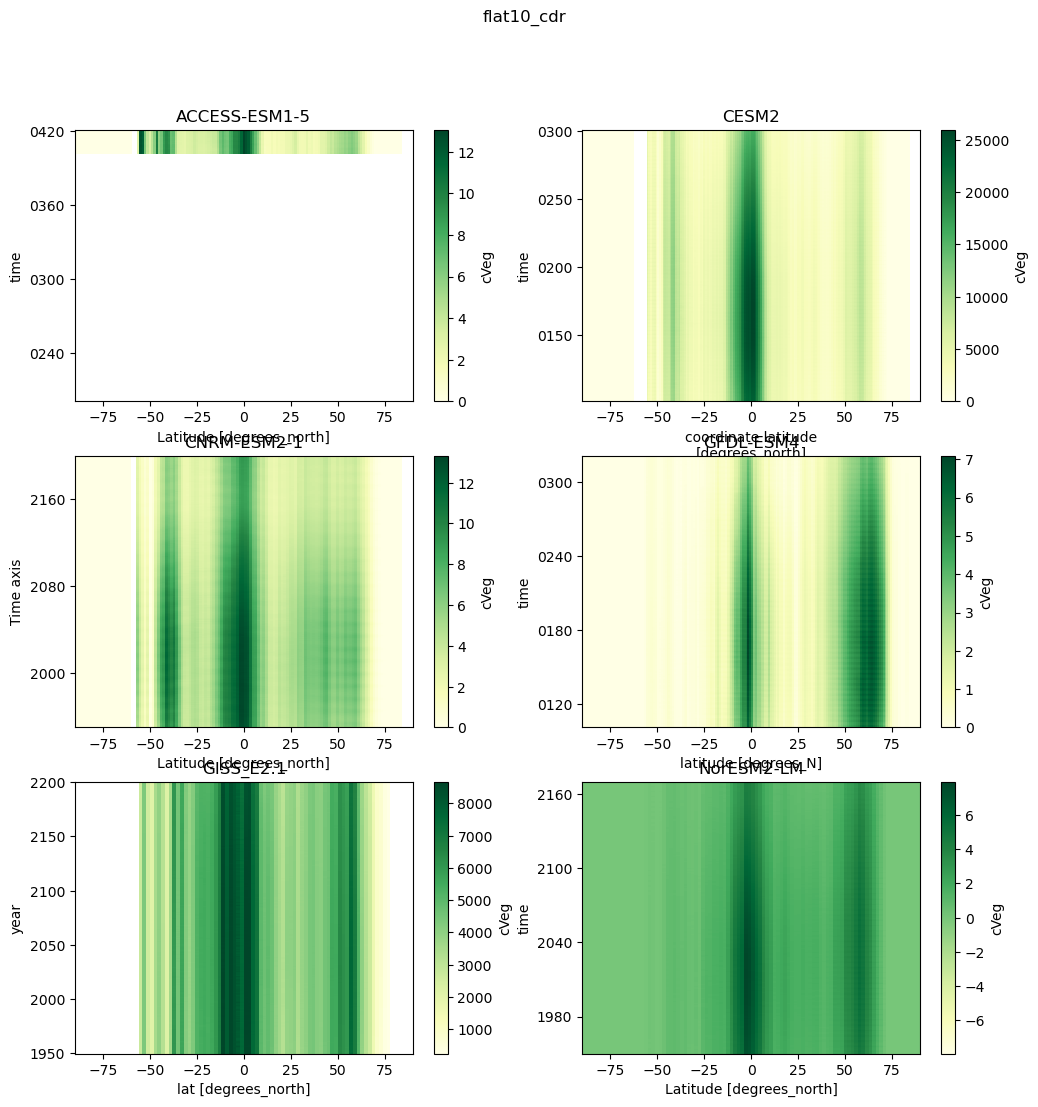

done saving file


In [151]:
# zonal by time plots
run=runlist[2]
var='cVeg'

plot_all_models_zonal_by_time(var, run, modellist, modellist_safe)

# #---------# Snippets below #-----------#

In [104]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +' = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

ACCESS_flat10 = dsmerge_v.copy(deep=True)
ACCESS_flat10_zec = dsmerge_v.copy(deep=True)
ACCESS_flat10_cdr = dsmerge_v.copy(deep=True)
CESM2_flat10 = dsmerge_v.copy(deep=True)
CESM2_flat10_zec = dsmerge_v.copy(deep=True)
CESM2_flat10_cdr = dsmerge_v.copy(deep=True)
CNRM_flat10 = dsmerge_v.copy(deep=True)
CNRM_flat10_zec = dsmerge_v.copy(deep=True)
CNRM_flat10_cdr = dsmerge_v.copy(deep=True)
GFDL_flat10 = dsmerge_v.copy(deep=True)
GFDL_flat10_zec = dsmerge_v.copy(deep=True)
GFDL_flat10_cdr = dsmerge_v.copy(deep=True)
GISS_flat10 = dsmerge_v.copy(deep=True)
GISS_flat10_zec = dsmerge_v.copy(deep=True)
GISS_flat10_cdr = dsmerge_v.copy(deep=True)
NorESM2_flat10 = dsmerge_v.copy(deep=True)
NorESM2_flat10_zec = dsmerge_v.copy(deep=True)
NorESM2_flat10_cdr = dsmerge_v.copy(deep=True)


In [255]:
def plot_all_models_one_deltavar(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,14))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print(model)    
        # create datasets for each model + experiment combination + variable
        exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
        print(exestr)
        exec(exestr, globals())
        #ds = model_run.var
        
        ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())

        if model == 'GISS_E2.1':
            arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
        else:
            arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))
    
        fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
    
        fg.axes.coastlines()
        plt.title(model)
    
    # add a title over the whole figure with the name of the run
    fig.suptitle(run)
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [ ]:
def plot_all_models_zonal_by_time(var, run, modellist, modellist_safe):
    # zonal plots
    
   
    #def plot_all_models_one_var(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,12))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
    
        # create datasets for each model + experiment combination + variable
        exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
        print(exestr)
        exec(exestr, globals())
        #ds = model_run.var
        
        ax=plt.subplot(3,2,m+1)
    
        if model == 'GISS_E2.1':
            arg=(ds.mean(dim='lon'))
        else:
            arg=(ds.mean(dim='lon'))
    
        fg = arg.plot(x='lat',cmap='YlGn')
        plt.xlim([-90, 90])
        
        plt.title(model)
    
    fig.suptitle(run)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

ds=ACCESS_flat10.cVeg
ds=CESM2_flat10.cVeg
ds=CNRM_flat10.cVeg
ds=GFDL_flat10.cVeg
ds=GISS_flat10.cVeg
ds=NorESM2_flat10.cVeg


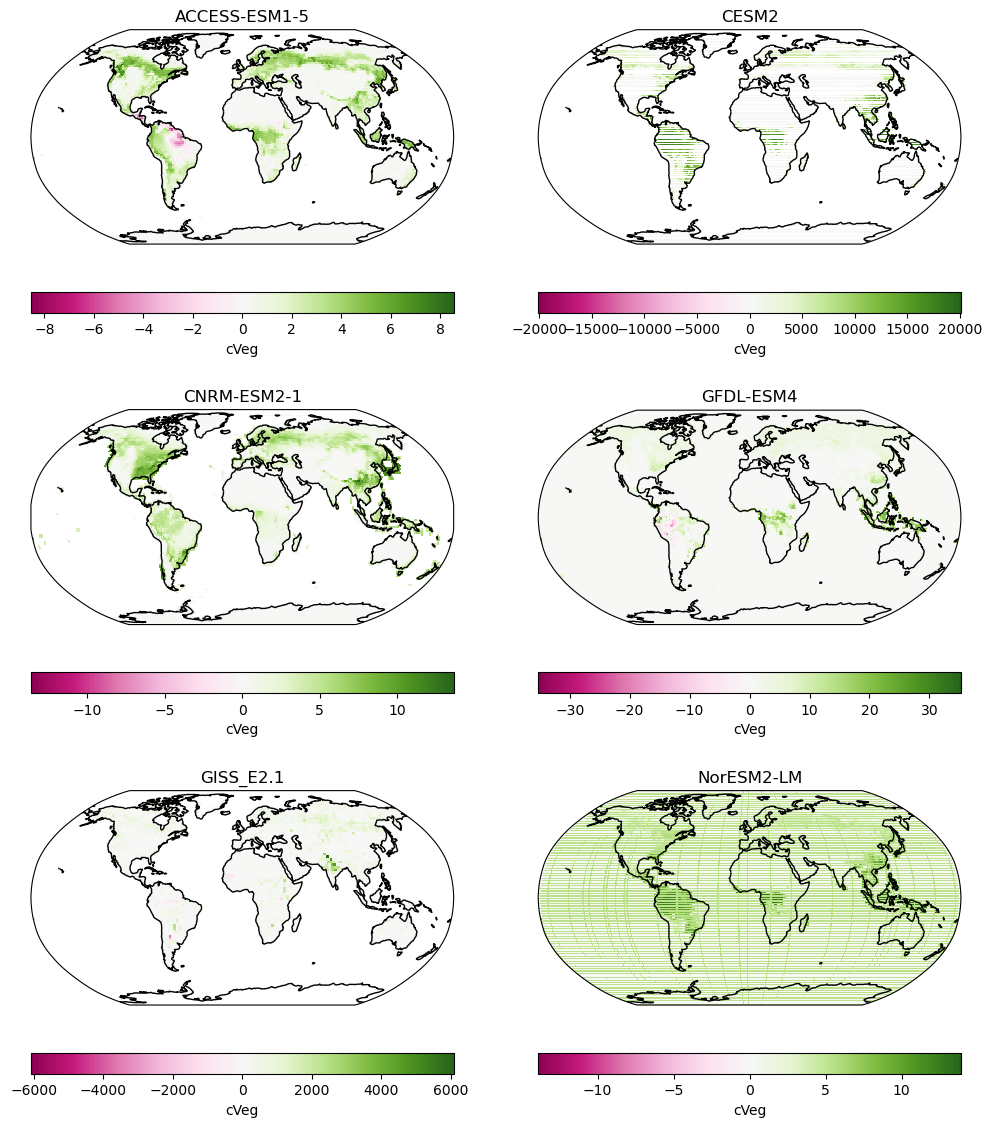

done saving file


In [65]:
run=runlist[0]
var='cVeg'

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,14))

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # create datasets for each model + experiment combination + variable
    exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr)
    #ds = model_run.var
    
    ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())

    if model == 'GISS_E2.1':
        arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
    else:
        arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))

    fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')

    fg.axes.coastlines()
    plt.title(model)


# show the plot:
plt.show()

# save the plot
fig.savefig('figures/' +run +'_' +var +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

ds0=CESM2_flat10.cVeg
ds1=CESM2_flat10_zec.cVeg
ds2=CESM2_flat10_cdr.cVeg


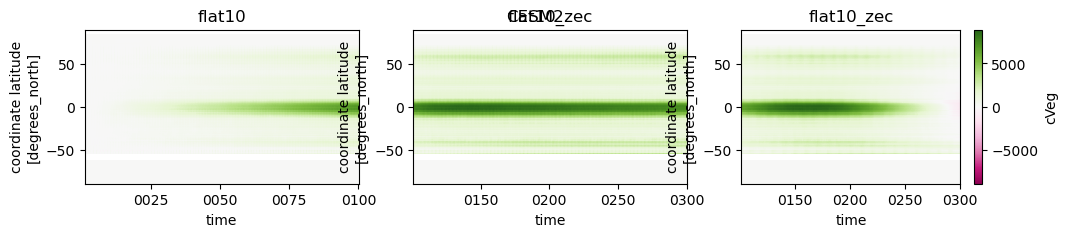

done saving file


In [210]:
# zonal plots
m=1
var='cVeg'
clim=8000

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,2))

# loop over models
#for m in range(len(modellist)):
model=modellist[m]

# create datasets for each model + experiment combination + variable
run=runlist[0]
exestr= 'ds0=' +modellist_safe[m] +'_' +run +'.' +var
print(exestr)
exec(exestr, globals())
#ds = model_run.var

dsinit=ds0.sel(time=slice(cftime.DatetimeNoLeap(1, 2, 1,has_year_zero=True),cftime.DatetimeNoLeap(3, 2, 1,has_year_zero=True))).mean(dim='time')

run=runlist[1]
exestr= 'ds1=' +modellist_safe[m] +'_' +run +'.' +var
print(exestr)
exec(exestr, globals())
#ds = model_run.var

run=runlist[2]
exestr= 'ds2=' +modellist_safe[m] +'_' +run +'.' +var
print(exestr)
exec(exestr, globals())
#ds = model_run.var

#-- now plot

#-flat10 first
#ax=plt.subplot(1,4,1)
#st=cftime.DatetimeNoLeap(1, 2, 1,has_year_zero=True)
#et=cftime.DatetimeNoLeap(3, 1, 1,has_year_zero=True)

#fg = (ds0.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='YlGn',add_colorbar=True)
#plt.ylim([-90, 90])

ax=plt.subplot(1,3,1)
#arr0=ds0.mean(dim='lon')

st=cftime.DatetimeNoLeap(1, 2, 1,has_year_zero=True)
et=cftime.DatetimeNoLeap(100, 1, 1,has_year_zero=True)

fg = (ds0.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False,vmax=clim,vmin=-clim)
plt.ylim([-90, 90])

plt.title(runlist[0])

#-flat10zec
ax=plt.subplot(1,3,2)

#arr0=ds0.mean(dim='lon')

st=cftime.DatetimeNoLeap(100, 2, 1,has_year_zero=True)
et=cftime.DatetimeNoLeap(300, 1, 1,has_year_zero=True)

fg = (ds1.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False)
plt.ylim([-90, 90])

plt.title(runlist[1])

#-flat10zec
ax=plt.subplot(1,3,3)

#arr0=ds0.mean(dim='lon')

st=cftime.DatetimeNoLeap(100, 2, 1,has_year_zero=True)
et=cftime.DatetimeNoLeap(300, 1, 1,has_year_zero=True)

fg = (ds2.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG')
plt.ylim([-90, 90])

plt.title(runlist[1])


fig.suptitle(model)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' +model +'_' +var +'_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

In [222]:
# zonal plots

def plot_zonal_allexp(var, m, modellist, modellist_safe,timename,clim):
    fig = plt.figure(figsize=(12,3))
    
    # loop over models
    #for m in range(len(modellist)):
    
    
    # create datasets for each model + experiment combination + variable
    run=runlist[0]
    exestr= 'ds0=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr, globals())
    #ds = model_run.var
    
    dsinit=ds0.sel(time=slice(cftime.DatetimeNoLeap(1+startyear-1, 2, 1,has_year_zero=True),
                              cftime.DatetimeNoLeap(3+startyear-1, 2, 1,has_year_zero=True))).mean(dim='time')
    
    run=runlist[1]
    exestr= 'ds1=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr, globals())
    #ds = model_run.var
    
    run=runlist[2]
    exestr= 'ds2=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr, globals())
    #ds = model_run.var
    
    #-- now plot
    
    #-flat10 first
    #ax=plt.subplot(1,4,1)
    #st=cftime.DatetimeNoLeap(1, 2, 1,has_year_zero=True)
    #et=cftime.DatetimeNoLeap(3, 1, 1,has_year_zero=True)
    
    #fg = (ds0.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='YlGn',add_colorbar=True)
    #plt.ylim([-90, 90])
    
    ax=plt.subplot(1,3,1)
    #arr0=ds0.mean(dim='lon')
    
    st=cftime.DatetimeNoLeap(1+startyear-1, 2, 1,has_year_zero=True)
    et=cftime.DatetimeNoLeap(100+startyear-1, 1, 1,has_year_zero=True)
    
    fg = (ds0.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False,vmax=clim,vmin=-clim)
    plt.ylim([-90, 90])
    
    plt.title(runlist[0])
    
    #-flat10zec
    ax=plt.subplot(1,3,2)
    
    #arr0=ds0.mean(dim='lon')
    
    st=cftime.DatetimeNoLeap(100+startyear-1, 2, 1,has_year_zero=True)
    et=cftime.DatetimeNoLeap(300+startyear-1, 1, 1,has_year_zero=True)
    
    fg = (ds1.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False)
    plt.ylim([-90, 90])
    
    plt.title(runlist[1])
    
    #-flat10zec
    ax=plt.subplot(1,3,3)
    
    #arr0=ds0.mean(dim='lon')
    
    st=cftime.DatetimeNoLeap(100+startyear-1, 2, 1,has_year_zero=True)
    et=cftime.DatetimeNoLeap(300+startyear-1, 1, 1,has_year_zero=True)
    
    fg = (ds2.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG')
    plt.ylim([-90, 90])
    
    plt.title(runlist[1])
    
    
    fig.suptitle(model)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +model +'_' +var +'_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [223]:

cftimetype = [
    'DatetimeNoLeap'
    'DatetimeGregorian'


m=2
var='cVeg'
clim=8000
startyear=1850
plot_zonal_allexp(var, m, modellist, modellist_safe,startyear,clim)

ds0=CNRM_flat10.cVeg


TypeError: cannot compare cftime.DatetimeGregorian(1920, 7, 16, 12, 0, 0, 0, has_year_zero=False) and cftime.DatetimeNoLeap(1850, 2, 1, 0, 0, 0, 0, has_year_zero=True)

<Figure size 1200x300 with 0 Axes>

In [225]:
modellist

DatetimeProlepticGregorian
DatetimeNoLeap
DatetimeGregorian
DatetimeNoLeap
year
DatetimeNoLeap

101
1
1850
1
1850
1850

['ACCESS-ESM1-5',
 'CESM2',
 'CNRM-ESM2-1',
 'GFDL-ESM4',
 'GISS_E2.1',
 'NorESM2-LM']

In [231]:
NorESM2_flat10

<xarray.Dataset>
Dimensions:    (time: 1799, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1850-02-15 00:00:00 ... 1999-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1850-02-01 00:00:00 ... 2000-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.05 -89.05 ... 89.05 90.0
    lon_bnds   (time, lon, bnds) float64 -1.25 1.25 1.25 ... 356.2 356.2 358.7
    cVeg       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cLitter    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cSoil      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1851-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               cVeg
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/0cb7c5f5-4b67-43dd-8f6f-c9376572aadb

In [ ]:
# zonal plots

run=runlist[0]
var='cVeg'

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # create datasets for each model + experiment combination + variable
    exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr)
    #ds = model_run.var
    
    ax=plt.subplot(3,2,m+1)

    if model == 'GISS_E2.1':
        #arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year')).mean(dim='lon')
        arg=(ds.mean(dim='lon'))
    else:
        #arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time')).mean(dim='lon')
        arg=(ds.mean(dim='lon'))

    fg = arg.plot(x='lat',cmap='YlGn')
    plt.xlim([-90, 90])
    
    plt.title(model)

fig.suptitle(run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

ds=ACCESS_flat10_zec.cVeg
ds=CESM2_flat10_zec.cVeg
ds=CNRM_flat10_zec.cVeg
ds=GFDL_flat10_zec.cVeg
ds=GISS_flat10_zec.cVeg
ds=NorESM2_flat10_zec.cVeg


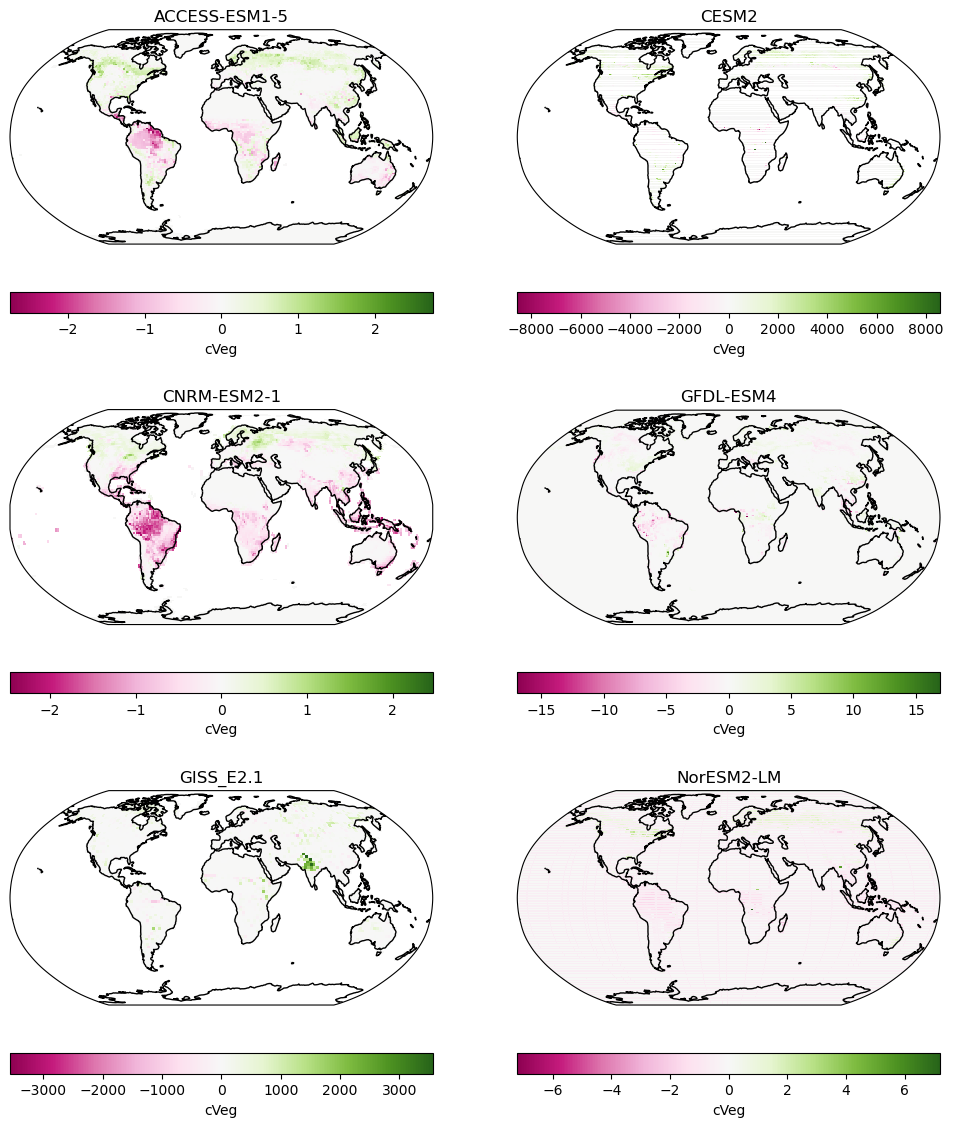

done saving file


In [66]:
#building the function

r=1
var='cVeg'

fig = plt.figure(figsize=(12,14))

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # create datasets for each model + experiment combination + variable
    exestr= 'ds=' +modellist_safe[m] +'_' +runlist[r] +'.' +var
    print(exestr)
    exec(exestr)
    #ds = model_run.cVeg
    
    #ax = plt.subplot(9,4,i+1,projection=ccrs.Robinson())
    ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())
    #ds_delta[var][:,:,i].plot()#vmin=-2, vmax=2, cmap=)
    if model == 'GISS_E2.1':
        arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
    else:
        arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))

    fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
#    fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'vertical'},cmap='PiYG')

    fg.axes.coastlines()
    plt.title(model)


# show the plot:
plt.show()

# save the plot
fig.savefig('figures/' +runlist[r] +'_' +var +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

TypeError: 'Text' object is not callable

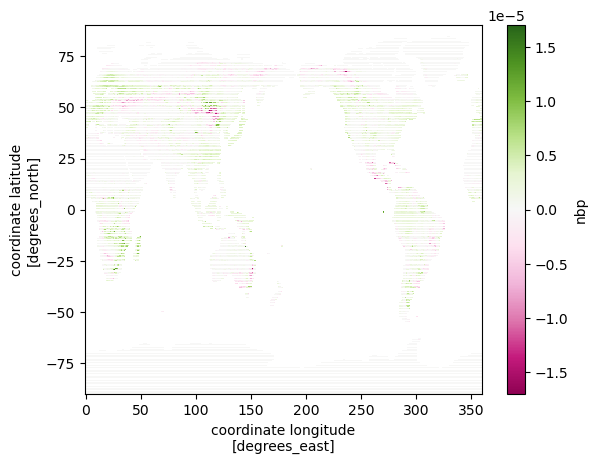

In [41]:
# difference in cVeg between end of flat10 and beginning of flat10
(CESM2_flat10.nbp[-23:-1,:,:].mean(dim='time')-CESM2_flat10.nbp[0:23,:,:].mean(dim='time')).plot(cmap='PiYG')

In [ ]:
#---------# Snippets below #-----------#

In [ ]:
for f in range(len(filenamelist)):
    file = filenamelist[f]
    if f==0:
        dsmerge_f2 = xr.open_dataset(file, use_cftime=True)
    else:
        ds = xr.open_dataset(file, use_cftime=True)
        dsmerge_f2.combine_first(ds)#],dim='time')
        #ds2=ddsmerge_f.combine_first(ds1)

dsmerge_f2

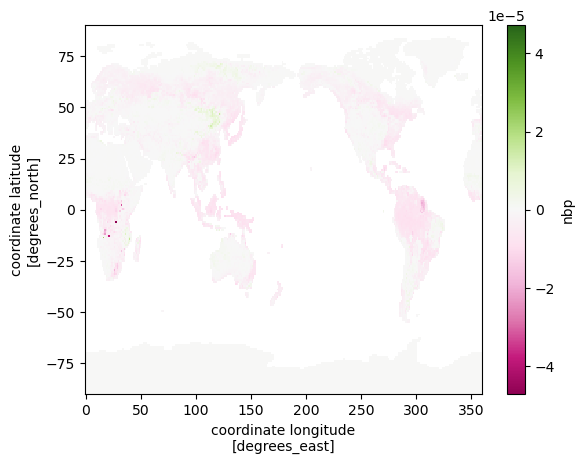

In [42]:
# the stripes in the CESM output are an artefact of the postprocessing. 
#The original variable named file looks fine, but the version that was uploaded to NIRD and then downloaded has stripes
# need to figure out how to fix that

ds=xr.open_dataset('/glade/u/home/aswann/scratch/flat10/TimeSeries/b.e21.B1850.f09_g17.FLAT10-cdr.001.clm2.h0.ts.allyears.nbp.nc')

(ds.nbp[-23:-1,:,:].mean(dim='time')-ds.nbp[0:23,:,:].mean(dim='time')).plot(cmap='PiYG')

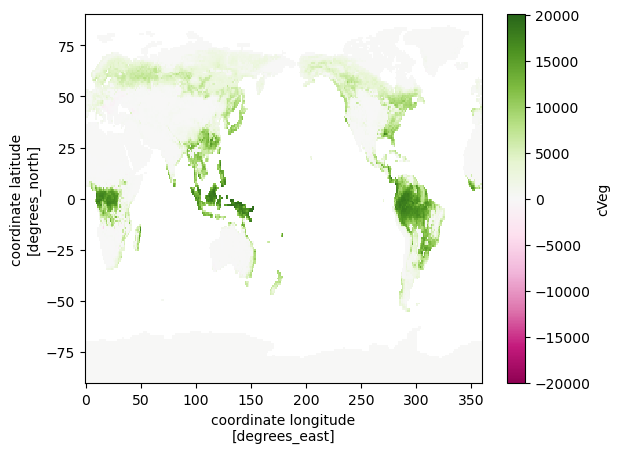

In [89]:
#/glade/campaign/cgd/tss/people/aswann/flat10/CESM2/flat10/b.e21.B1850.f09_g17.FLAT10-esm.001.clm2.h0.ts.allyears.cVeg.nc

ds=xr.open_dataset('/glade/campaign/cgd/tss/people/aswann/flat10/CESM2/flat10/b.e21.B1850.f09_g17.FLAT10-esm.001.clm2.h0.ts.allyears.nbp.nc', use_cftime=True)
ds2=xr.open_dataset('/glade/campaign/cgd/tss/people/aswann/flat10/CESM2/flat10/b.e21.B1850.f09_g17.FLAT10-esm.001.clm2.h0.ts.allyears.cVeg.nc', use_cftime=True)

ds3=xr.merge([ds, ds2])

ds4=ds3.copy(deep=True)

(ds4.cVeg[-23:-1,:,:].mean(dim='time')-ds4.cVeg[0:23,:,:].mean(dim='time')).plot(cmap='PiYG')

ModuleNotFoundError: No module named 'xcollection'

<xarray.Dataset>
Dimensions:      (time: 2520, hist_interval: 2, lon: 288, lat: 192)
Coordinates:
  * time         (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
  * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds  (time, hist_interval) object 0000-12-31 23:30:00 ... 0211-01...
    nbp          (time, lat, lon) float32 ...
    cVeg         (time, lat, lon) float32 ...
Attributes: (12/101)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Tue May 14 13:33:44 2024: ncre...
    source:                                    Community Land Model CLM4.0
    hostname:                                  derecho
    ...                                        ...
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    NCO:                                       netCDF Operators version 5.1.9...

In [38]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
modellist=['NorESM2-LM']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            filenamelist= glob.glob(searchpath)
            
            dsmerge_f=xr.open_mfdataset(filenamelist)

            # merge all variables into one dataset
            # this could potentially be done with xr.open_mfdatset all in one go, but for now:
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

        if model !='GISS_E2.1':
            # add  land fraction and area of gridcells to the dataframe
            dsmerge_v = xr.merge([dsmerge_v, areacella, landfrac],compat='override')
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +' = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

ACCESS_flat10 = dsmerge_v.copy(deep=True)
ACCESS_flat10_zec = dsmerge_v.copy(deep=True)
ACCESS_flat10_cdr = dsmerge_v.copy(deep=True)


In [87]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
modellist=['NorESM2-LM']
modellist_safe = ['NorESM2']

searchpathappend=[]

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            
            #filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points

        
        searchpath= outputdir +model +'/' +run +'/*Lmon' +'*.nc'
        dsmerge_v = xr.open_mfdataset(searchpath, use_cftime=True)


        if model !='GISS_E2.1':
            # add  land fraction and area of gridcells to the dataframe
            dsmerge_v = xr.merge([dsmerge_v, areacella, landfrac],compat='override')

        searchpathappend=[]
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +'_mf = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

NorESM2_flat10_mf = dsmerge_v.copy(deep=True)


MergeError: conflicting values for variable 'type' on objects to be combined. You can skip this check by specifying compat='override'.

In [238]:
data_dict = {
    'CESM2_flat10': CESM2_flat10,
    'CESM2_flat10_zec': CESM2_flat10_zec
}

data_dict['CESM2_flat10_cdr'] = CESM2_flat10_cdr

In [239]:
data_dict

{'CESM2_flat10': <xarray.Dataset>
 Dimensions:      (time: 2520, hist_interval: 2, lon: 288, lat: 192)
 Coordinates:
   * time         (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
   * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * lat          (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
 Dimensions without coordinates: hist_interval
 Data variables:
     time_bounds  (time, hist_interval) object 0000-12-31 23:30:00 ... 0211-01...
     cVeg         (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
     cLitter      (time, lat, lon) float32 ...
     cSoil        (time, lat, lon) float32 ...
     nbp          (time, lat, lon) float32 ...
 Attributes: (12/101)
     title:                                     CLM History file information
     comment:                                   NOTE: None of the variables ar...
     Conventions:                               CF-1.0
     history:                              

In [ ]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
modellist=['CESM2']#['NorESM2-LM']
modellist_safe = ['CESM2']#['NorESM2']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

        if model !='GISS_E2.1':
            # add  land fraction and area of gridcells to the dataframe
            dsmerge_v = xr.merge([dsmerge_v, areacella, landfrac])#,compat='override')
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +' = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

In [ ]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        print(model +' getting grid info')
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_areacella = areacella.copy(deep=True)'
        exec(exestr)

        exestr= modellist_safe[m] +'_landfrac = landfrac.copy(deep=True)'
        exec(exestr)